In [1]:
import pandas as pd 
from tensorly.decomposition import tucker

import matplotlib.pyplot as plt 


In [2]:
df = pd.read_csv('resources/data/taz.view_moveandchill.csv',index_col='id')
COLUMN_MAP =  {
    'objectid'      : 'ID',
    'sensor_eui'    : 'sensor_ID',
    'zeitpunkt'     : 'timestamp',
    'temperature'   : 'temperature',
    'humidity'      : 'humidity',
    'latitude'      : 'latitude', 
    'longitude'     : 'longitude',
    'noise'         : 'noise',
    'sit'           : "% occupancy"   # every 15-30 mins the sensor resets and checks occupancy 
    
}
df.rename(columns=COLUMN_MAP,inplace=True)
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y%m%d%H%M%S')
df['timestamp'] = (df['timestamp'] - df['timestamp'].iloc[0]).dt.total_seconds().astype(int)
df = df.sort_values(by='timestamp',ascending=True)


In [3]:
to_ignore = ['0080E115003BB3B8','0080E115003BCA81','0080E115003BC9A9','0080E1150017F416','0080E115003BCA25']
df = df[~df['sensor_ID'].isin(to_ignore)]
print(df.groupby('sensor_ID').size().sort_values())

sensor_ID
0080E11500180306    1700
0080E1150017F5F8    1720
0080E115003BC2AD    2188
0080E115003BC996    2208
0080E115003BCA55    2348
0080E1150017A139    2444
0080E115003BE631    2480
0080E115003BC8D7    2504
0080E115003BDA59    2524
0080E115003BCF64    2556
0080E115003BC812    2560
0080E115003BC1DF    2564
dtype: int64


In [4]:
sensor_IDs = df['sensor_ID'].unique().tolist()
N_sensors   = len(sensor_IDs)
FEATURES = ['humidity','noise', 'temperature']
N_timepoints = 1700

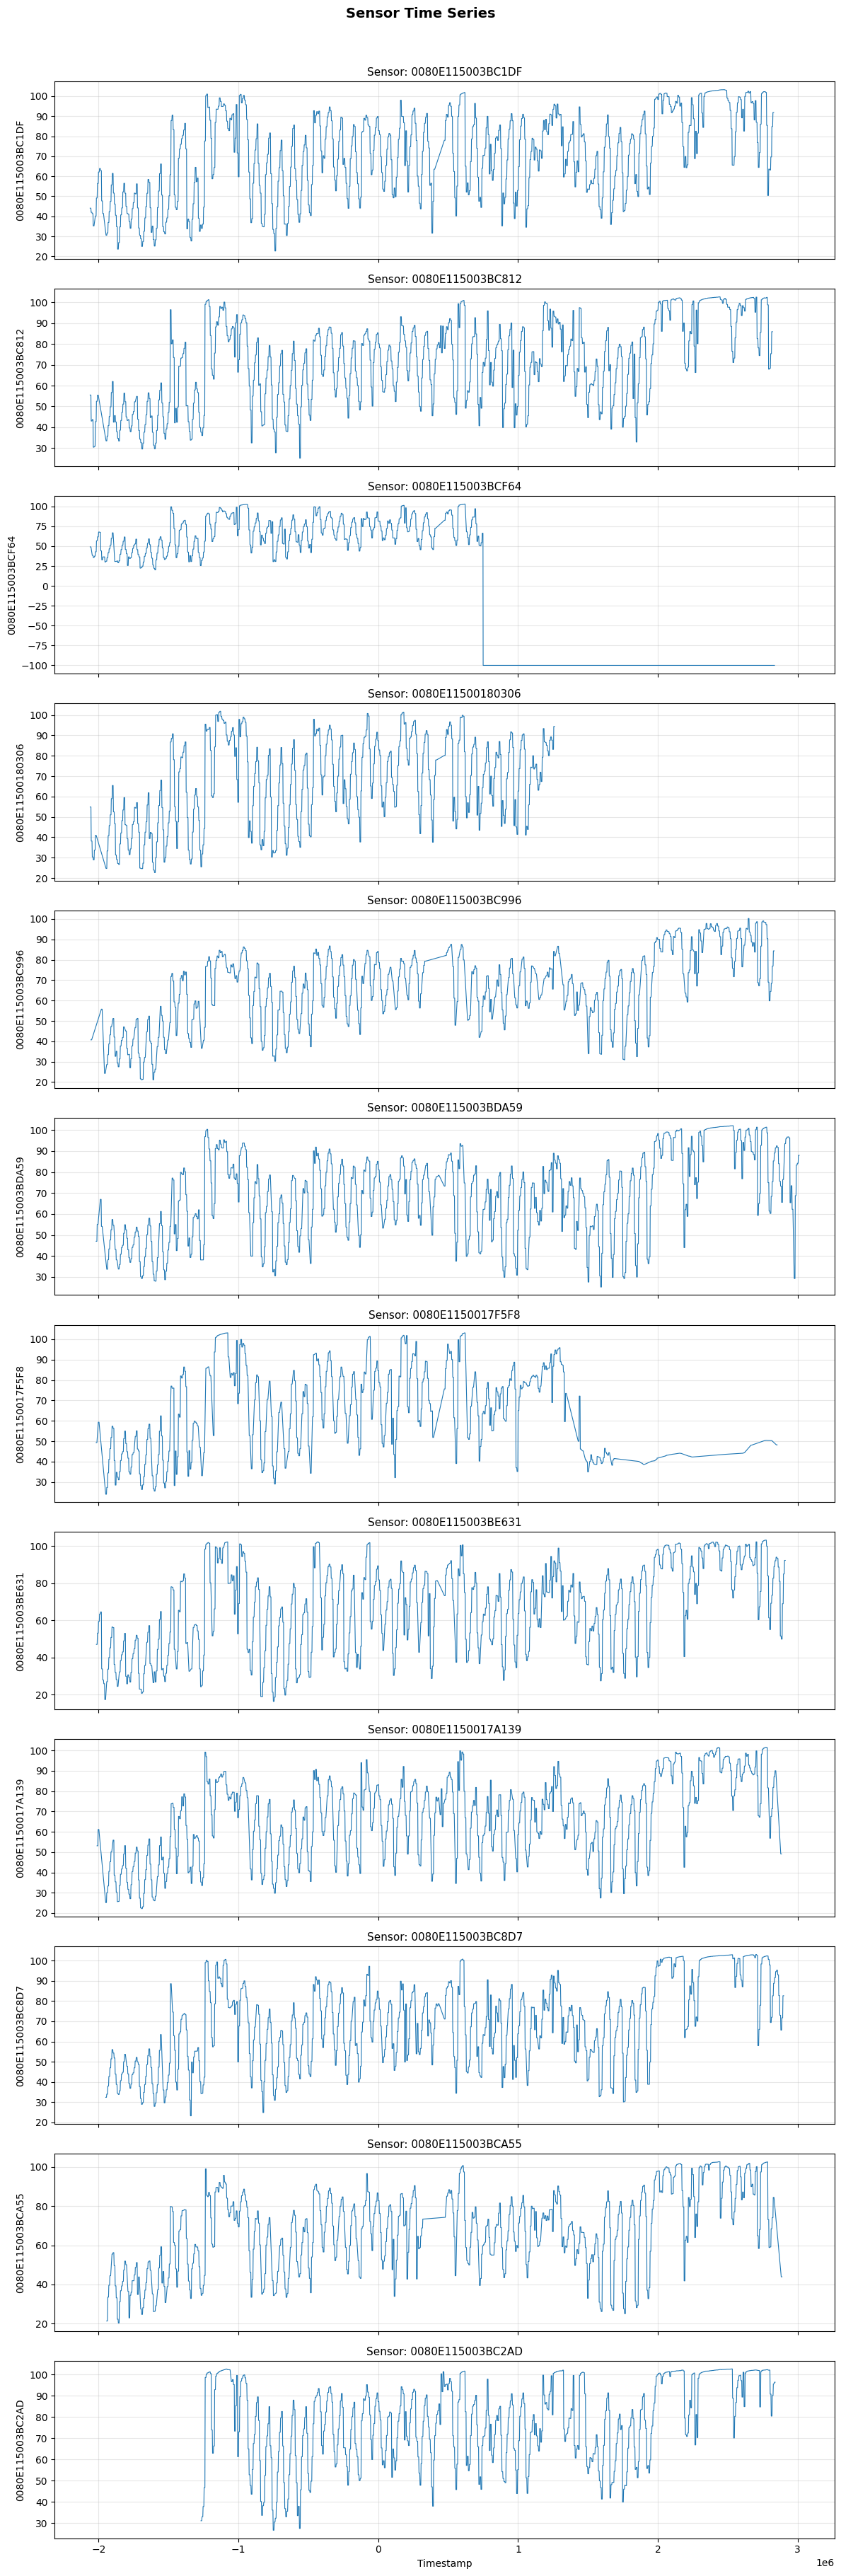

In [5]:
import matplotlib.pyplot as plt

sensors = df['sensor_ID'].unique().tolist()
fig, axes = plt.subplots(len(sensors), 1, figsize=(12, 3 * len(sensors)), sharex=True)

for ax, sensor in zip(axes, sensors):
    df1 = df[(df['sensor_ID'] == sensor)]
    # df1 = df[(df['sensor_ID'] == sensor) & (df['timestamp'] < 10000)][:250]
    ax.plot(df1['timestamp'], df1['humidity'], linewidth=0.8)
    ax.set_ylabel(sensor, fontsize=10)
    ax.set_title(f'Sensor: {sensor}', fontsize=11)
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel('Timestamp')
fig.suptitle('Sensor Time Series', fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

In [8]:
pd.to_numeric(df['sensor_ID'],errors='coerce')

id
5260    NaN
5264    NaN
5268    NaN
5276    0.0
5259    NaN
       ... 
4385    NaN
4708    NaN
4707    NaN
4706    NaN
4705    NaN
Name: sensor_ID, Length: 27796, dtype: float64

In [13]:
from sklearn.cluster import KMeans, DBSCAN 
from sklearn.metrics import adjusted_rand_score, silhouette_score,confusion_matrix
from scipy.optimize import linear_sum_assignment


sensor_coords = (df.groupby('sensor_ID')[['latitude','longitude']]
                    .mean()
                    .reset_index() 
                    )
coords = sensor_coords[['latitude','longitude']].values
N_clusters = 2 

In [22]:
from sklearn.preprocessing import StandardScaler

coords_scaled = StandardScaler().fit_transform(coords)
kmeans = KMeans(n_clusters=N_clusters,random_state=42,init='k-means++')
sensor_coords['cluster_kmeans'] = kmeans.fit_predict(coords_scaled) * 50

In [23]:
sensor_coords['cluster_kmeans'].value_counts()

cluster_kmeans
50    7
0     5
Name: count, dtype: int64

In [27]:
import plotly.express as px

# df2 = df[df['sit'] > 60]
fig = px.scatter_map(
    sensor_coords,
    lat="latitude",
    lon="longitude",
    color='sensor_ID',
    range_color=[0, 100], 
    zoom=12,
    height=500,
)
fig.update_layout(mapbox_style="open-street-map")

scale_lon_start = sensor_coords['longitude'].min() + 0.01
scale_lon_end = scale_lon_start + 0.01  # roughly ~1 km depending on latitude
scale_lat = sensor_coords['latitude'].min() + 0.01

fig.add_shape(
    type="line",
    x0=scale_lon_start,
    y0=scale_lat,
    x1=scale_lon_end,
    y1=scale_lat,
    line=dict(color="black", width=4),
    xref="x",
    yref="y"
)

# Add text annotation for the scale
fig.add_annotation(
    x=(scale_lon_start + scale_lon_end)/2,
    y=scale_lat + 0.002,  # slightly above line
    text="~1 km",
    showarrow=False,
    font=dict(color="black", size=12),
    xref="x",
    yref="y"
)

fig.show()

# Pre-processing

In [167]:
from sklearn.preprocessing import StandardScaler 
df[FEATURES] = StandardScaler().fit_transform(df[FEATURES])

In [168]:
import numpy as np 



df_trimmed = (
    df.groupby('sensor_ID')
    .apply(lambda x: x.nsmallest(N_timepoints, 'timestamp'))
    .reset_index(drop=True)
)

sensor_ids = df_trimmed['sensor_ID'].unique()

reshaped = np.array([
    df_trimmed[df_trimmed['sensor_ID'] == sid][FEATURES].values[:N_timepoints].T  # (n_features, N_timepoints)
    for sid in sensor_ids
])  # (Nbat, Nvar, timepoints)

C:\Users\tudor\AppData\Local\Temp\ipykernel_27556\1253578864.py:7: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.nsmallest(N_timepoints, 'timestamp'))


In [169]:
%load_ext autoreload 
%autoreload 2 
from tucker3 import Tucker3

model = Tucker3(LowRankApprox=np.array([3,3,3]), maxIter=100, tolCriteria=0.02,ErrorScaled=True)

# TODO error with scaling not being updated correctly ...
results             = model.fit_transform(reshaped,verbose=False)
_, XT_scaled, _     = model.transform(reshaped,verbose=True)
metrics             = model.calcContribution(XT_scaled)

A = results['scores']
B = results['varLoadings']
C = results['timeLoadings']
F = results['coreTensor'] 

HT2             = model.calcIMD(input=reshaped,metric="HotellingT2").reshape(N_sensors,1)
DModX           = model.calcOOMD(input=reshaped,metric="DModX").reshape(N_sensors,1)

df_out          = pd.DataFrame(np.hstack((HT2,DModX)),columns=("HT2","DModX"),index=sensor_ids)
df_out['T_SPE'] = metrics['T_SPE']
df_out['TSQR']  = metrics['TSQR']
new_cols        = [f"con_TSQR_{feat}" for feat in FEATURES]
df_out[new_cols]= metrics['con_TSQR']
df_iSPE         = pd.DataFrame(metrics['iSPE_batch'],columns=FEATURES,index=sensor_ids)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [170]:
df_out['LV1'] = results['scores'][:,0]
for i in range(results['scores'].shape[1] - 1):
    df_out[f'LV{i+2}'] = results['scores'][:,i+1]


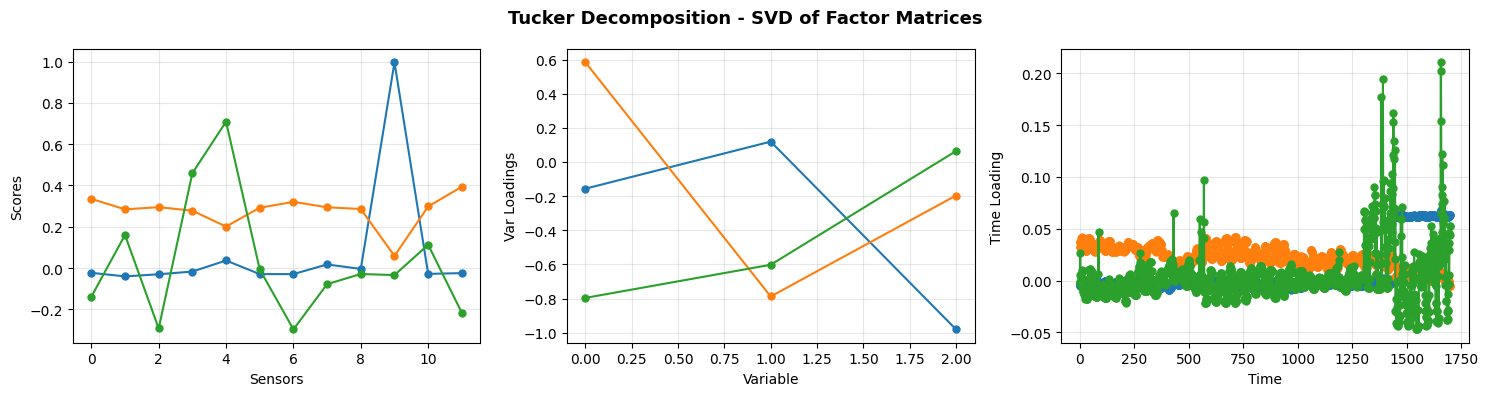

In [171]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))


axes[0].plot(A,'o-',linewidth=1.5,markersize=5)
axes[0].set_xlabel('Sensors')
axes[0].set_ylabel('Scores')
axes[0].grid(True,alpha=0.3)

axes[1].plot(B,'o-',linewidth=1.5,markersize=5)
axes[1].set_xlabel('Variable')
axes[1].set_ylabel('Var Loadings')
axes[1].grid(True,alpha=0.3)

axes[2].plot(C,'o-',linewidth=1.5,markersize=5)
axes[2].set_xlabel("Time")
axes[2].set_ylabel("Time Loading")
axes[2].grid(True, alpha=0.3)


fig.suptitle('Tucker Decomposition - SVD of Factor Matrices', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

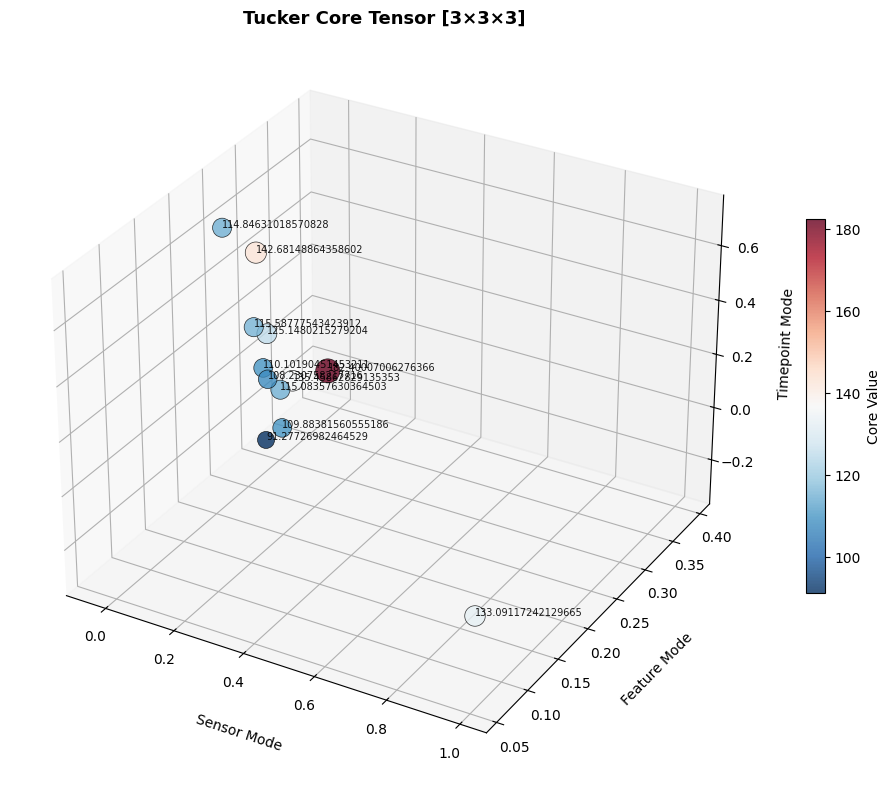

In [172]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

x, y, z = np.meshgrid(3,3,3, indexing='ij')
values = F.numpy() if hasattr(F, 'numpy') else np.array(F)

x = df_out['LV1']
y = df_out['LV2']
z = df_out['LV3']
v = df_out['TSQR']
labels = df_out.index.astype(str).to_numpy()

sc = ax.scatter(x, y, z,
                c=v,
                s=np.abs(v) / np.abs(v).max() * 300,
                cmap='RdBu_r',
                alpha=0.8,
                edgecolors='k',
                linewidths=0.5)

for i, (xi, yi, zi, vi) in enumerate(zip(x, y, z, v)):
    ax.text(xi, yi, zi, vi, fontsize=7, alpha=0.9)

plt.colorbar(sc, ax=ax, label='Core Value', shrink=0.5)

ax.set_xlabel('Sensor Mode', labelpad=15)
ax.set_ylabel('Feature Mode', labelpad=15)
ax.set_zlabel('Timepoint Mode', labelpad=10)
ax.set_title('Tucker Core Tensor [3×3×3]', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

C:\Users\tudor\AppData\Local\Temp\ipykernel_27556\397073076.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_iSPE1,palette='viridis',ax=axes[0])
C:\Users\tudor\AppData\Local\Temp\ipykernel_27556\397073076.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(),rotation=45,ha='right')
C:\Users\tudor\AppData\Local\Temp\ipykernel_27556\397073076.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_iSPE2,palette='viridis',ax=axes[1])
C:\Users\tudor\AppData\Local\Temp\ipykernel_27556\397073076.py:18: UserWarning: set_ticklabels() should only be us

[Text(0, 0, 'con_TSQR_humidity'),
 Text(1, 0, 'con_TSQR_noise'),
 Text(2, 0, 'con_TSQR_temperature')]

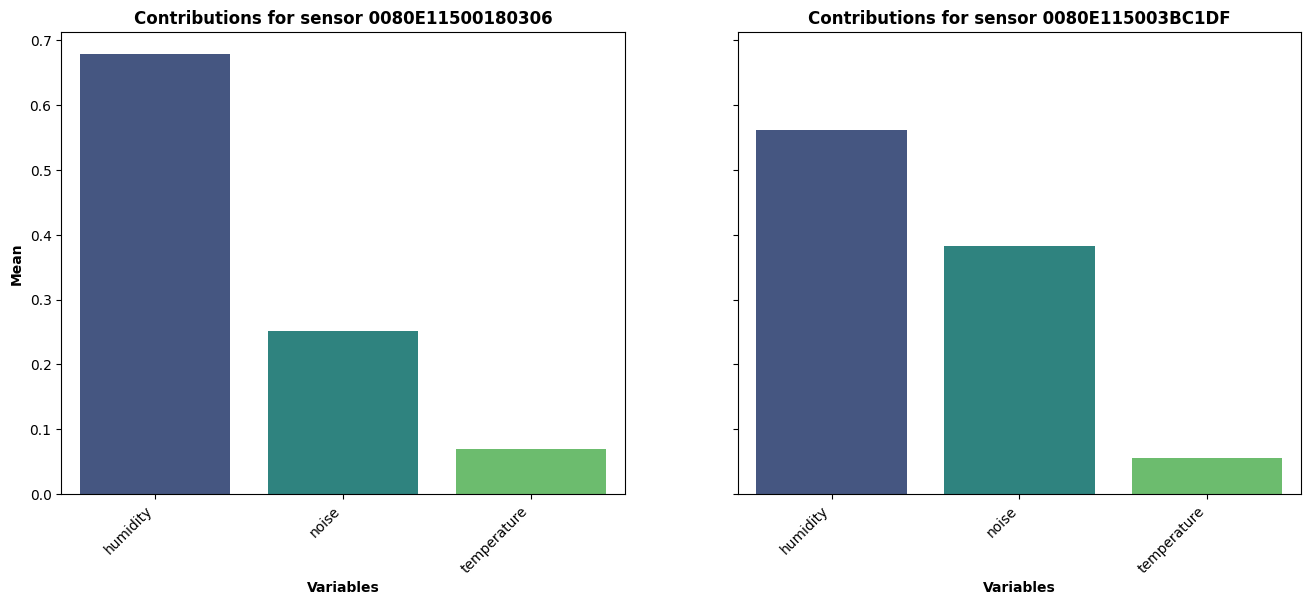

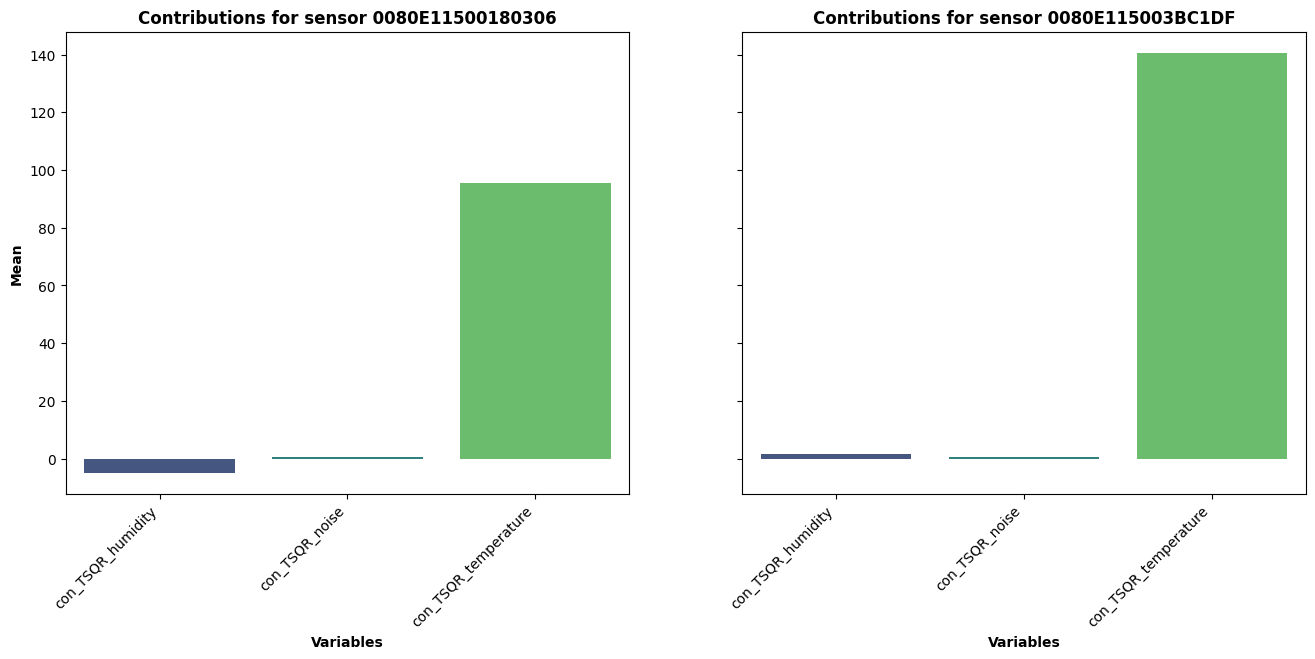

In [173]:
import seaborn as sns 
sensor1 = '0080E11500180306'
sensor2 = '0080E115003BC1DF'
df_iSPE1 = df_iSPE.loc[sensor1]
df_iSPE2 = df_iSPE.loc[sensor2]

fig, axes = plt.subplots(1,2, figsize=(16,6), sharey=True)
sns.barplot(data=df_iSPE1,palette='viridis',ax=axes[0])
axes[0].set_xlabel('Variables',fontweight='bold')
axes[0].set_ylabel('Mean',fontweight='bold')
axes[0].set_title(f'Contributions for sensor {sensor1}',fontweight='bold')
axes[0].set_xticklabels(axes[0].get_xticklabels(),rotation=45,ha='right')

sns.barplot(data=df_iSPE2,palette='viridis',ax=axes[1])
axes[1].set_xlabel('Variables',fontweight='bold')
axes[1].set_ylabel('Mean',fontweight='bold')
axes[1].set_title(f'Contributions for sensor {sensor2}',fontweight='bold')
axes[1].set_xticklabels(axes[1].get_xticklabels(),rotation=45,ha='right')


import seaborn as sns 
sensor1 = '0080E11500180306'
sensor2 = '0080E115003BC1DF'
new_cols        = [f"con_TSQR_{feat}" for feat in FEATURES]
df_iSPE1 = df_out.loc[sensor1,new_cols]
df_iSPE2 = df_out.loc[sensor2,new_cols]

fig, axes = plt.subplots(1,2, figsize=(16,6), sharey=True)
sns.barplot(data=df_iSPE1,palette='viridis',ax=axes[0])
axes[0].set_xlabel('Variables',fontweight='bold')
axes[0].set_ylabel('Mean',fontweight='bold')
axes[0].set_title(f'Contributions for sensor {sensor1}',fontweight='bold')
axes[0].set_xticklabels(axes[0].get_xticklabels(),rotation=45,ha='right')

sns.barplot(data=df_iSPE2,palette='viridis',ax=axes[1])
axes[1].set_xlabel('Variables',fontweight='bold')
axes[1].set_ylabel('Mean',fontweight='bold')
axes[1].set_title(f'Contributions for sensor {sensor2}',fontweight='bold')
axes[1].set_xticklabels(axes[1].get_xticklabels(),rotation=45,ha='right')


In [174]:
import matplotlib.patches as mpatches 
from scipy.stats import chi2 

def ellipse_confidence(df,x_col='TSQR',y_col='DModX',confidence=0.95,facecolor='none',edgecolor='darkred'):
    x_all = df[x_col].to_numpy()
    y_all = df[y_col].to_numpy()

    xy = np.column_stack((x_all,y_all))
    mu  = xy.mean(axis=0)
    cov = np.cov(xy,rowvar=False)

    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals = eigvals[order]
    eigvecs = eigvecs[:, order]

    chi2_q = chi2.ppf(confidence,df=2)
    width = 2. * np.sqrt(eigvals[0] * chi2_q)
    height = 2. * np.sqrt(eigvals[1] * chi2_q)

    angle = np.degrees(np.arctan2(eigvecs[1,0], eigvecs[0,0]))
    ell = mpatches.Ellipse(xy=mu,width=width,height=height,angle=angle,facecolor=facecolor,edgecolor=edgecolor,alpha=0.12,zorder=1,linewidth=1.)

    inv_cov = np.linalg.pinv(cov)
    diffs = xy - mu 
    d2 = np.einsum("ij, jk, ik->i",diffs,inv_cov,diffs)
    outside_mask = d2 > chi2_q
    outside_ids = list(df.index.astype(str).to_numpy()[outside_mask])

    return ell, outside_ids

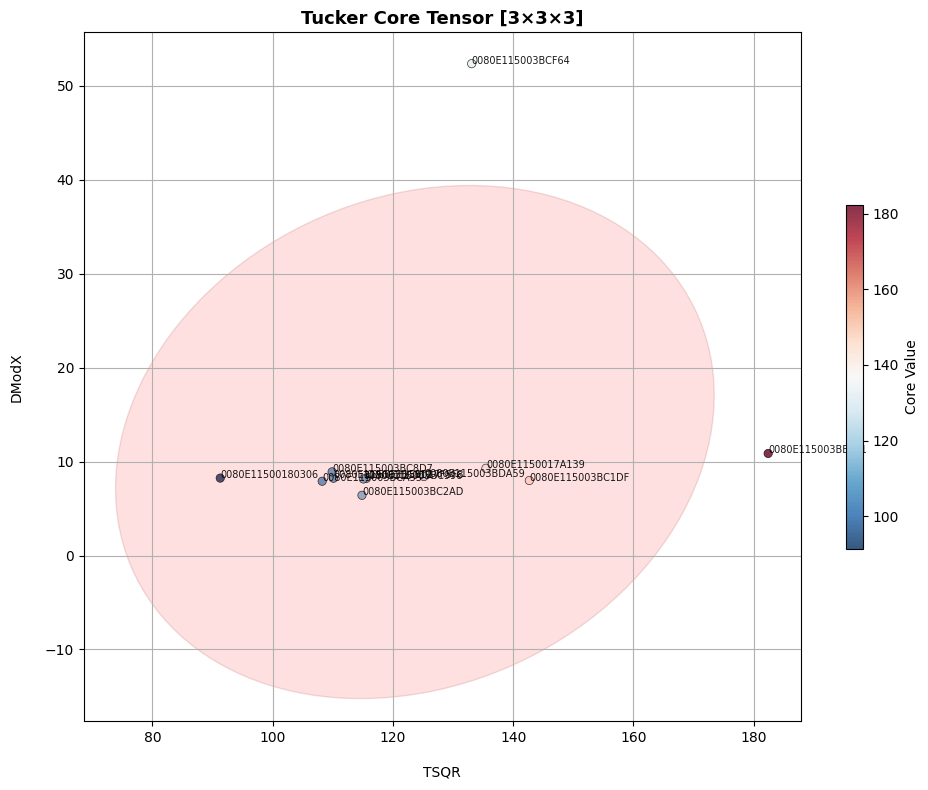

In [175]:
fig = plt.figure(figsize=(10, 8))
ax = plt.axes() 


x = df_out['TSQR']
y = df_out['DModX']
# z = df_out['LV3']
col= df_out['TSQR']
v = df_out.index.astype(str).to_numpy()

sc = ax.scatter(x, y, 
                c=col,
                # s=np.abs(v) / np.abs(v).max() * 300,
                cmap='RdBu_r',
                alpha=0.8,
                edgecolors='k',
                linewidths=0.5)
ell95,mask = ellipse_confidence(df_out,confidence=0.90,facecolor='red',edgecolor='darkred')
ax.add_patch(ell95)
for i, (xi, yi, vi) in enumerate(zip(x, y, v)):
    ax.text(xi, yi, vi, fontsize=7, alpha=0.9)

plt.colorbar(sc, ax=ax, label='Core Value', shrink=0.5)

ax.set_xlabel('TSQR', labelpad=15)
ax.set_ylabel('DModX', labelpad=15)
ax.set_title('Tucker Core Tensor [3×3×3]', fontsize=13, fontweight='bold')

plt.tight_layout()
ax.grid(True)
plt.show()